In [ ]:
import os
import torch
from utils import GMM4PR, get_dataset, build_model, build_decoder_from_flag
from typing import Tuple, Dict, Any

def load_gmm_config(gmm_path: str) -> Dict[str, Any]:
    """
    Load the configuration from a saved GMM checkpoint.
    
    Args:
        gmm_path: Path to the GMM checkpoint file (.pt)
        
    Returns:
        Dictionary containing both GMM config and full experiment config
    """
    if not os.path.isfile(gmm_path):
        raise FileNotFoundError(f"GMM checkpoint not found: {gmm_path}")
    
    ckpt = torch.load(gmm_path, map_location="cpu", weights_only=False)
    
    if "config" not in ckpt:
        raise ValueError(f"No config found in checkpoint: {gmm_path}")
    
    gmm_config = ckpt["config"]
    
    # The full experiment config is stored inside gmm_config["config"]
    exp_config = gmm_config.get("config", {})
    
    print(f"✓ Loaded config from: {gmm_path}")
    print(f"  Experiment: {exp_config.get('exp_name', 'N/A')}")
    print(f"  Dataset: {exp_config.get('dataset', 'N/A')}")
    print(f"  Architecture: {exp_config.get('arch', 'N/A')}")
    print(f"  K: {gmm_config['K']}, latent_dim: {gmm_config['latent_dim']}")
    print(f"  Condition mode: {gmm_config.get('cond_mode', 'None')}")
    print(f"  Covariance type: {gmm_config.get('cov_type', 'diag')}")
    print(f"  Perturbation: {gmm_config.get('budget', {})}")
    
    return gmm_config


def load_gmm_model(gmm_path: str, device: str = "cuda") -> Tuple[GMM4PR, Any, Any, Any]:
    """
    Load a complete GMM model from checkpoint with all necessary components.
    
    Args:
        gmm_path: Path to the GMM checkpoint file (.pt)
        device: Device to load the model to ('cuda' or 'cpu')
        
    Returns:
        Tuple of (gmm_model, classifier_model, feat_extractor, up_sampler)
    """
    # Step 1: Load configuration
    gmm_config = load_gmm_config(gmm_path)
    exp_config = gmm_config.get("config", {})
    
    # Extract necessary config values
    dataset_name = exp_config.get("dataset", "cifar10")
    data_root = exp_config.get("data_root", "./dataset")
    arch = exp_config.get("arch", "resnet18")
    clf_ckpt = exp_config.get("clf_ckpt")
    use_decoder = exp_config.get("use_decoder", False)
    decoder_backend = exp_config.get("decoder_backend", "bicubic")
    latent_dim = gmm_config["latent_dim"]
    
    # Step 2: Load dataset to get output shape
    print(f"\n{'='*60}")
    print("Loading dataset...")
    dataset, num_classes, out_shape = get_dataset(dataset_name, data_root, train=True, resize=False)
    print(f"  Dataset: {dataset_name}, Classes: {num_classes}, Shape: {out_shape}")
    
    # Step 3: Load classifier and feature extractor
    print(f"\n{'='*60}")
    print(f"Loading classifier: {arch}")
    print(f"  Device: {device}")
    
    if not clf_ckpt or not os.path.isfile(clf_ckpt):
        raise FileNotFoundError(f"Classifier checkpoint not found: {clf_ckpt}")
    
    model, feat_extractor = build_model(arch, num_classes, device)
    
    # Load classifier weights
    state = torch.load(clf_ckpt, map_location="cpu", weights_only=False)
    state = state.get("state_dict", state.get("model_state", state))
    state = {k.replace("module.", ""): v for k, v in state.items()}
    
    model.load_state_dict(state, strict=False)
    model = model.to(device).eval()
    for p in model.parameters():
        p.requires_grad = False
    
    feat_extractor = feat_extractor.to(device).eval()
    for p in feat_extractor.parameters():
        p.requires_grad = False
    
    # Check parameter sharing
    model_params = {id(p) for p in model.parameters()}
    feat_params = {id(p) for p in feat_extractor.parameters()}
    shared = model_params & feat_params
    
    print(f"  Model params: {len(model_params)}, Feat extractor params: {len(feat_params)}")
    if shared:
        print(f"  Shared parameters: {len(shared)}")
    
    # Step 4: Build decoder/up_sampler if needed
    up_sampler = None
    if use_decoder:
        print(f"\n{'='*60}")
        print(f"Building decoder: {decoder_backend}")
        up_sampler = build_decoder_from_flag(
            decoder_backend,
            latent_dim,
            out_shape,
            device
        )
        print(f"  ✓ Decoder built successfully!")
    else:
        print(f"\n{'='*60}")
        print(f"No decoder used (use_decoder={use_decoder})")
    
    # Step 5: Load the GMM model
    print(f"\n{'='*60}")
    print(f"Loading GMM model from: {gmm_path}")
    gmm = GMM4PR.load_from_checkpoint(
        gmm_path,
        feat_extractor=feat_extractor,
        up_sampler=up_sampler,
        map_location=device,
        strict=True
    )
    
    gmm = gmm.to(device).eval()
    print(f"✓ GMM model loaded successfully!")
    print(f"{'='*60}\n")
    
    return gmm, gmm_config, model, feat_extractor, up_sampler


print("Functions defined: load_gmm_config(), load_gmm_model()")

# Example usage: Load a GMM model from checkpoint

# Specify the GMM checkpoint path
GMM_PATH_list = ["ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(none)_decoder(trainable_128)_linf(16)_reg(none).pt", 
                 "ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(y)_decoder(trainable_128)_linf(16)_reg(none).pt",
                 "ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(x)_decoder(trainable_128)_linf(16)_reg(none).pt",
                 "ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(xy)_decoder(trainable_128)_linf(16)_reg(none).pt"
                 ]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the complete GMM model
gmm_dict = {'gmm':[], 'cfg':[], 'model':[], 'feat_extractor':[], 'up_sampler':[]}
for GMM_PATH in GMM_PATH_list:
    gmm, cfg, model, feat_extractor, up_sampler = load_gmm_model(GMM_PATH, device=DEVICE)

    gmm_dict['gmm'].append(gmm)
    gmm_dict['cfg'].append(cfg)
    gmm_dict['model'].append(model)
    gmm_dict['feat_extractor'].append(feat_extractor)
    gmm_dict['up_sampler'].append(up_sampler)

print("\nAll components loaded and ready for analysis!")

Functions defined: load_gmm_config(), load_gmm_model()
✓ Loaded config from: ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(none)_decoder(trainable_128)_linf(16)_reg(none).pt
  Experiment: K7_cond(none)_decoder(trainable_128)_linf(16)_reg(none)
  Dataset: tinyimagenet
  Architecture: resnet18
  K: 7, latent_dim: 128
  Condition mode: None
  Covariance type: full
  Perturbation: {'norm': 'linf', 'eps': 0.06274509803921569}

Loading dataset...
  Dataset: tinyimagenet, Classes: 200, Shape: (3, 64, 64)

Loading classifier: resnet18
  Device: cuda
  Model params: 62, Feat extractor params: 60
  Shared parameters: 60

Building decoder: bicubic_trainable
[Decoder 'bicubic'] 18,963 params
  ✓ Decoder built successfully!

Loading GMM model from: ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(none)_decoder(trainable_128)_linf(16)_reg(none).pt
[Params] Shared trunk: 0 | pi: 7 | mu: 896, | cov: 114,688 | Total: 115,591
Model loaded from ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(none)_de

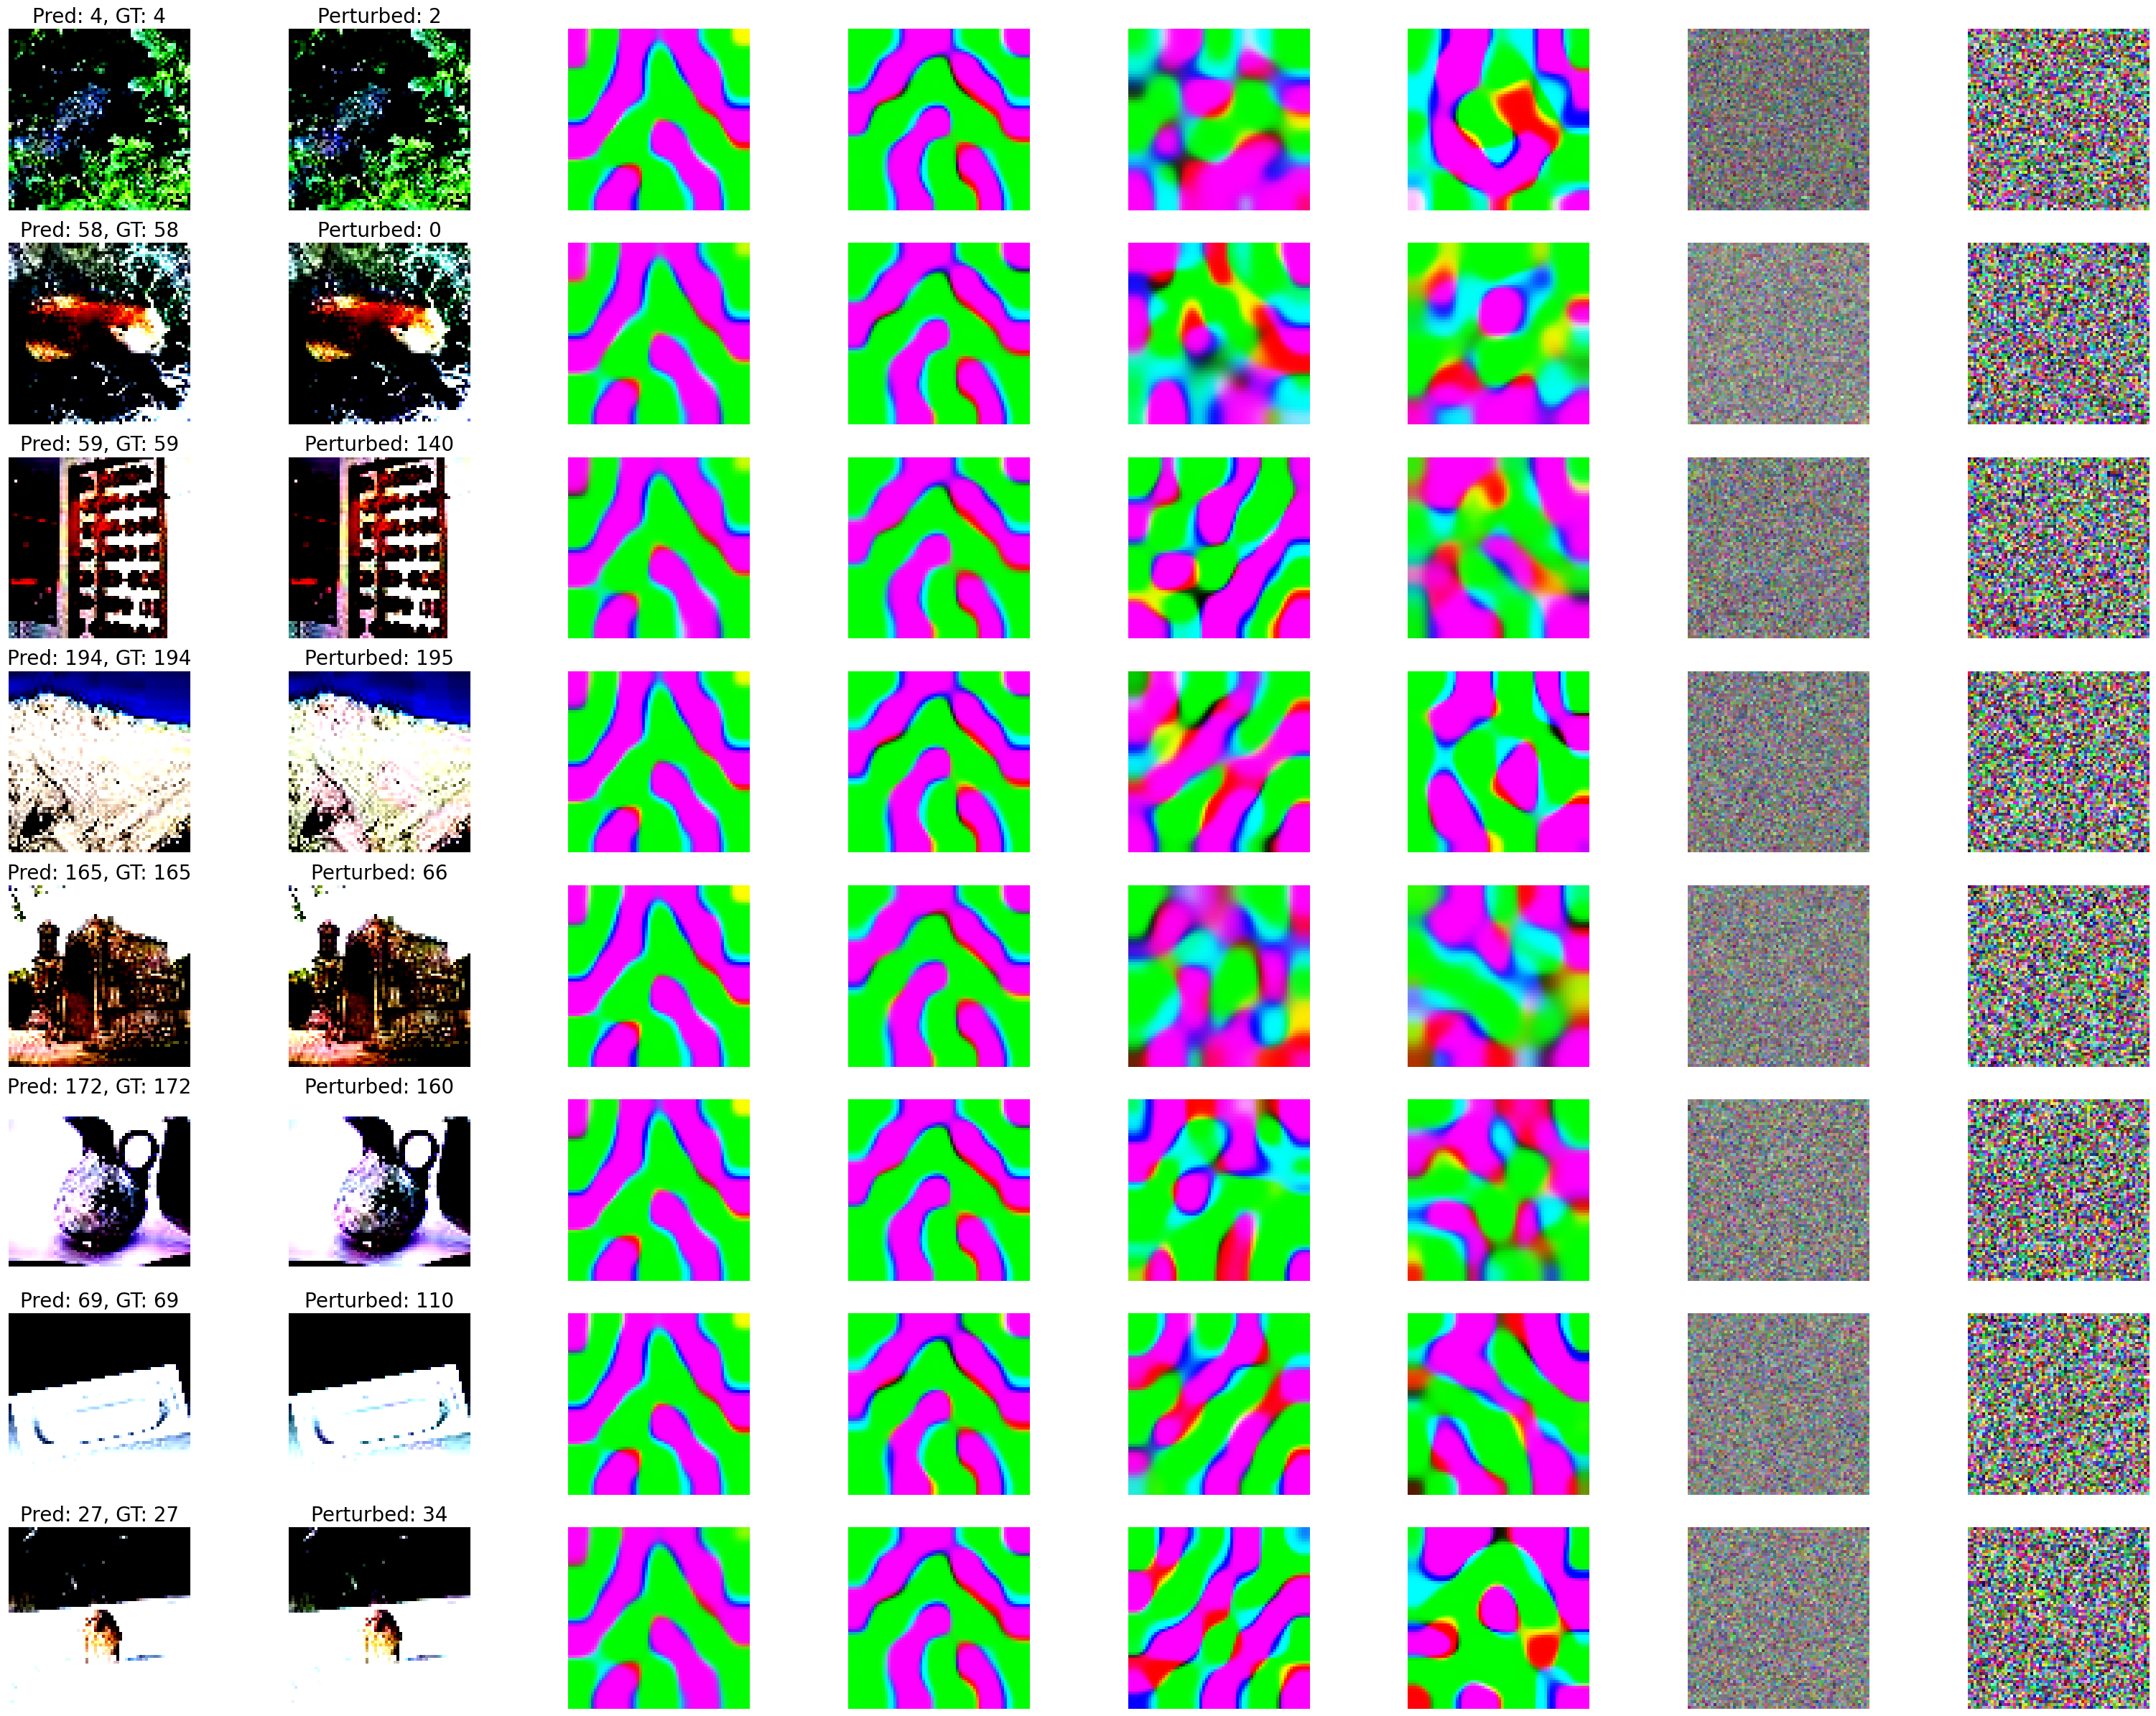

In [4]:
import os
import torch
from utils import GMM4PR, get_dataset, build_model, build_decoder_from_flag
from typing import Tuple, Dict, Any

def load_gmm_config(gmm_path: str) -> Dict[str, Any]:
    """
    Load the configuration from a saved GMM checkpoint.
    
    Args:
        gmm_path: Path to the GMM checkpoint file (.pt)
        
    Returns:
        Dictionary containing both GMM config and full experiment config
    """
    if not os.path.isfile(gmm_path):
        raise FileNotFoundError(f"GMM checkpoint not found: {gmm_path}")
    
    ckpt = torch.load(gmm_path, map_location="cpu", weights_only=False)
    
    if "config" not in ckpt:
        raise ValueError(f"No config found in checkpoint: {gmm_path}")
    
    gmm_config = ckpt["config"]
    
    # The full experiment config is stored inside gmm_config["config"]
    exp_config = gmm_config.get("config", {})
    
    print(f"✓ Loaded config from: {gmm_path}")
    print(f"  Experiment: {exp_config.get('exp_name', 'N/A')}")
    print(f"  Dataset: {exp_config.get('dataset', 'N/A')}")
    print(f"  Architecture: {exp_config.get('arch', 'N/A')}")
    print(f"  K: {gmm_config['K']}, latent_dim: {gmm_config['latent_dim']}")
    print(f"  Condition mode: {gmm_config.get('cond_mode', 'None')}")
    print(f"  Covariance type: {gmm_config.get('cov_type', 'diag')}")
    print(f"  Perturbation: {gmm_config.get('budget', {})}")
    
    return gmm_config


def load_gmm_model(gmm_path: str, device: str = "cuda") -> Tuple[GMM4PR, Any, Any, Any]:
    """
    Load a complete GMM model from checkpoint with all necessary components.
    
    Args:
        gmm_path: Path to the GMM checkpoint file (.pt)
        device: Device to load the model to ('cuda' or 'cpu')
        
    Returns:
        Tuple of (gmm_model, classifier_model, feat_extractor, up_sampler)
    """
    # Step 1: Load configuration
    gmm_config = load_gmm_config(gmm_path)
    exp_config = gmm_config.get("config", {})
    
    # Extract necessary config values
    dataset_name = exp_config.get("dataset", "cifar10")
    data_root = exp_config.get("data_root", "./dataset")
    arch = exp_config.get("arch", "resnet18")
    clf_ckpt = exp_config.get("clf_ckpt")
    use_decoder = exp_config.get("use_decoder", False)
    decoder_backend = exp_config.get("decoder_backend", "bicubic")
    latent_dim = gmm_config["latent_dim"]
    
    # Step 2: Load dataset to get output shape
    print(f"\n{'='*60}")
    print("Loading dataset...")
    dataset, num_classes, out_shape = get_dataset(dataset_name, data_root, train=True, resize=False)
    print(f"  Dataset: {dataset_name}, Classes: {num_classes}, Shape: {out_shape}")
    
    # Step 3: Load classifier and feature extractor
    print(f"\n{'='*60}")
    print(f"Loading classifier: {arch}")
    print(f"  Device: {device}")
    
    if not clf_ckpt or not os.path.isfile(clf_ckpt):
        raise FileNotFoundError(f"Classifier checkpoint not found: {clf_ckpt}")
    
    model, feat_extractor = build_model(arch, num_classes, device)
    
    # Load classifier weights
    state = torch.load(clf_ckpt, map_location="cpu", weights_only=False)
    state = state.get("state_dict", state.get("model_state", state))
    state = {k.replace("module.", ""): v for k, v in state.items()}
    
    model.load_state_dict(state, strict=False)
    model = model.to(device).eval()
    for p in model.parameters():
        p.requires_grad = False
    
    feat_extractor = feat_extractor.to(device).eval()
    for p in feat_extractor.parameters():
        p.requires_grad = False
    
    # Check parameter sharing
    model_params = {id(p) for p in model.parameters()}
    feat_params = {id(p) for p in feat_extractor.parameters()}
    shared = model_params & feat_params
    
    print(f"  Model params: {len(model_params)}, Feat extractor params: {len(feat_params)}")
    if shared:
        print(f"  Shared parameters: {len(shared)}")
    
    # Step 4: Build decoder/up_sampler if needed
    up_sampler = None
    if use_decoder:
        print(f"\n{'='*60}")
        print(f"Building decoder: {decoder_backend}")
        up_sampler = build_decoder_from_flag(
            decoder_backend,
            latent_dim,
            out_shape,
            device
        )
        print(f"  ✓ Decoder built successfully!")
    else:
        print(f"\n{'='*60}")
        print(f"No decoder used (use_decoder={use_decoder})")
    
    # Step 5: Load the GMM model
    print(f"\n{'='*60}")
    print(f"Loading GMM model from: {gmm_path}")
    gmm = GMM4PR.load_from_checkpoint(
        gmm_path,
        feat_extractor=feat_extractor,
        up_sampler=up_sampler,
        map_location=device,
        strict=True
    )
    
    gmm = gmm.to(device).eval()
    print(f"✓ GMM model loaded successfully!")
    print(f"{'='*60}\n")
    
    return gmm, gmm_config, model, feat_extractor, up_sampler


print("Functions defined: load_gmm_config(), load_gmm_model()")

# Example usage: Load a GMM model from checkpoint

# Specify the GMM checkpoint path
GMM_PATH_list = ["ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(none)_decoder(trainable_128)_linf(16)_reg(none).pt", 
                 "ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(y)_decoder(trainable_128)_linf(16)_reg(none).pt",
                 "ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(x)_decoder(trainable_128)_linf(16)_reg(none).pt",
                 "ckp/gmm_ckp/resnet18_on_tinyimagenet/gmm_K7_cond(xy)_decoder(trainable_128)_linf(16)_reg(none).pt"
                 ]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load the complete GMM model
gmm_dict = {'gmm':[], 'cfg':[], 'model':[], 'feat_extractor':[], 'up_sampler':[]}
for GMM_PATH in GMM_PATH_list:
    gmm, cfg, model, feat_extractor, up_sampler = load_gmm_model(GMM_PATH, device=DEVICE)

    gmm_dict['gmm'].append(gmm)
    gmm_dict['cfg'].append(cfg)
    gmm_dict['model'].append(model)
    gmm_dict['feat_extractor'].append(feat_extractor)
    gmm_dict['up_sampler'].append(up_sampler)

print("\nAll components loaded and ready for analysis!")

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

@torch.no_grad()
def get_correctly_classified_batch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    batch_size: int,
    device: str = "cuda"
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Collect a batch of correctly classified images from a dataloader.
    
    Args:
        model: The classifier model
        dataloader: DataLoader to sample from
        batch_size: Number of correctly classified samples to collect
        device: Device to run on ('cuda' or 'cpu')
    
    Returns:
        Tuple of (images, labels) where:
            - images: Tensor of shape [batch_size, C, H, W]
            - labels: Tensor of shape [batch_size] (dtype: torch.long)
    """
    model.eval()
    
    collected_images = torch.tensor([], device=device)
    collected_labels = torch.tensor([], device=device, dtype=torch.long)
    
    for batch_data in dataloader:
        # Handle different dataloader formats
        if len(batch_data) == 3:
            x, y, _ = batch_data
        else:
            x, y = batch_data
            
        x, y = x.to(device), y.to(device)
        
        # Get predictions
        logits = model(x)
        preds = logits.argmax(dim=1)
        
        # Find correctly classified samples
        correct_mask = (preds == y)
        
        if correct_mask.sum() > 0:
            collected_images = torch.cat((collected_images, x[correct_mask]), dim=0)
            collected_labels = torch.cat((collected_labels, y[correct_mask]), dim=0)
        
        # Stop when we have enough samples
        if len(collected_images) >= batch_size:
            collected_images = collected_images[:batch_size]
            collected_labels = collected_labels[:batch_size]
            break
    
    print(f"Collected {len(collected_images)} correctly classified samples")
    return collected_images, collected_labels


@torch.no_grad()
def generate_successful_perturbations(
    images: torch.Tensor,
    labels: torch.Tensor,
    gmm_list: List[GMM4PR],
    classifier: torch.nn.Module,
    out_shape: Tuple[int, int, int],
    max_perturbations: int = 32,
    max_attempts: int = 256,
    device: str = "cuda",
    dependency_modes: List[str] = ["none", "label", "input", "joint"]
) -> Tuple[torch.Tensor, torch.Tensor, List[torch.Tensor], List[torch.Tensor]]:
    """
    Generate successful perturbations using multiple GMMs with different dependency modes.
    All perturbations are generated on the same set of images.
    
    Args:
        images: Batch of images [B, C, H, W]
        labels: Batch of labels [B]
        gmm_list: List of GMM4PR models (one per dependency mode)
        classifier: Classifier model
        out_shape: Output shape (C, H, W)
        max_perturbations: Maximum number of successful perturbations to collect
        max_attempts: Maximum number of attempts to generate perturbations
        device: Device to run on
        dependency_modes: List of dependency modes corresponding to gmm_list
    
    Returns:
        Tuple of (succ_images, succ_ground_truth, list_succ_perturbations, list_succ_labels) where:
            - succ_images: Tensor [N, C, H, W] - shared across all GMMs
            - succ_ground_truth: Tensor [N] - shared across all GMMs
            - list_succ_perturbations: List of N tensors, one per GMM
            - list_succ_labels: List of N tensors, one per GMM
    """
    images = images.to(device)
    labels = labels.to(device)
    
    # Get original predictions
    orig_logits = classifier(images)
    orig_preds = orig_logits.argmax(dim=-1)
    
    # Initialize collections for all GMMs
    list_succ_perturbations = []
    list_succ_labels = []
    
    # For each GMM, generate perturbations on the same images
    for gmm_idx, (gmm, dep_mode) in enumerate(zip(gmm_list, dependency_modes)):
        print(f"\nGMM {gmm_idx + 1}/{len(gmm_list)}: dependency mode = '{dep_mode}'")
        
        # Prepare arguments based on dependency mode
        if dep_mode == "none":
            sample_x, sample_y = None, None
        elif dep_mode == "input" or dep_mode == "x":
            sample_x, sample_y = images, None
        elif dep_mode == "label" or dep_mode == "y":
            sample_x, sample_y = None, labels
        elif dep_mode == "joint" or dep_mode == "xy":
            sample_x, sample_y = images, labels
        else:
            raise ValueError(f"Unknown dependency mode: {dep_mode}")
        
        print(f"  Generating up to {max_perturbations} successful perturbations...")
        
        # Collect successful perturbations for this GMM
        succ_perturbations = torch.tensor([], device='cpu')
        succ_labels_gmm = torch.tensor([], device='cpu', dtype=torch.long)
        succ_images = torch.tensor([], device='cpu')
        succ_ground_truth = torch.tensor([], device='cpu', dtype=torch.long)
        
        attempts = 0
        
        while len(succ_perturbations) < max_perturbations and attempts < max_attempts:
            # Sample perturbations
            if dep_mode == "none":
                sample_out = gmm.sample(x=sample_x, y=sample_y, num_samples=len(images), out_shape=out_shape)
                delta = sample_out["delta"].squeeze(1)
            else:
                sample_out = gmm.sample(x=sample_x, y=sample_y, num_samples=1, out_shape=out_shape)
            
                delta = sample_out["delta"].squeeze(0)  # [B, C, H, W]
            
            # Apply perturbations and get predictions
            perturbed_images = images + delta
            perturbed_logits = classifier(perturbed_images)
            perturbed_preds = perturbed_logits.argmax(dim=-1)
            
            # Check if perturbations successfully changed the prediction
            success_mask = (perturbed_preds != orig_preds)
            
            # Collect successful perturbations
            if success_mask.any():
                succ_perturbations = torch.cat((succ_perturbations, delta[success_mask].cpu()), dim=0)
                succ_labels_gmm = torch.cat((succ_labels_gmm, perturbed_preds[success_mask].cpu()), dim=0)
                succ_images = torch.cat((succ_images, images[success_mask].cpu()), dim=0)
                succ_ground_truth = torch.cat((succ_ground_truth, labels[success_mask].cpu()), dim=0)
            
            attempts += 1
        
        print(f"  Collected {len(succ_perturbations)} successful perturbations in {attempts} attempts")
        
        list_succ_perturbations.append(succ_perturbations)
        list_succ_labels.append(succ_labels_gmm)
    
    # Use the first GMM's successful images as the shared set
    # (all GMMs should generate perturbations on the same images)
    return succ_images, succ_ground_truth, list_succ_perturbations, list_succ_labels


def plot_perturbations(
    succ_images: torch.Tensor,
    succ_ground_truth: torch.Tensor,
    list_succ_perturbations: List[torch.Tensor],
    list_succ_labels: List[torch.Tensor],
    original_predictions: torch.Tensor = None,
    classifier: torch.nn.Module = None,
    class_names: List[str] = None,
    num_samples: int = None,
    figsize: Tuple[int, int] = None,
    normalize_perturbation: bool = True,
    dependency_modes: List[str] = ["none", "y", "x", "xy"]
):
    """
    Plot successful perturbations with multiple GMM dependency modes and comparison to random noise.

    Args:
        succ_images: Batch of original images [N, C, H, W]
        succ_ground_truth: Ground truth labels [N]
        list_succ_perturbations: List of perturbation tensors, one per GMM [N, C, H, W]
        list_succ_labels: List of predicted label tensors, one per GMM [N]
        original_predictions: Original predictions before perturbation [N] (optional)
        classifier: Classifier model to compute original predictions if not provided
        class_names: List of class names for display (optional)
        num_samples: Number of samples to plot (default: all)
        figsize: Figure size as (width, height) tuple (optional)
        normalize_perturbation: Whether to normalize perturbations to [0, 1] for visualization (default: True)
        dependency_modes: List of dependency mode names for column titles

    The plot shows:
        - Column 1: Original image
        - Column 2: Perturbed image (using last GMM, typically xy)
        - Columns 3-6: GMM perturbations (none, y, x, xy)
        - Columns 7-8: Gaussian and Uniform noise
    """
    FONTSIZE = 20

    # Move tensors to CPU for plotting
    succ_images = succ_images.cpu()
    succ_ground_truth = succ_ground_truth.cpu()
    list_succ_perturbations = [p.cpu() for p in list_succ_perturbations]
    list_succ_labels = [l.cpu() for l in list_succ_labels]

    # Compute original predictions if not provided
    if original_predictions is None:
        if classifier is None:
            raise ValueError("Either original_predictions or classifier must be provided")
        with torch.no_grad():
            original_predictions = classifier(succ_images.to(next(classifier.parameters()).device)).argmax(dim=-1).cpu()
    else:
        original_predictions = original_predictions.cpu()

    # Determine number of samples to plot
    N = len(succ_images)
    if num_samples is not None:
        N = min(N, num_samples)

    # Set figure size - now with 8 columns
    if figsize is None:
        figsize = (32, 3 * N)

    # Create figure with 8 columns
    fig, axes = plt.subplots(N, 8, figsize=figsize)

    # Handle single sample case
    if N == 1:
        axes = axes.reshape(1, -1)

    for i in range(N):
        # Get data for this sample
        img = succ_images[i]
        gt = succ_ground_truth[i].item()
        orig_pred = original_predictions[i].item()
        
        # Use the last GMM's perturbation (typically xy) for the perturbed image display
        pert = list_succ_perturbations[-1][i]
        pert_pred = list_succ_labels[-1][i].item()

        # Create perturbed image
        perturbed_img = img + pert

        # Generate random noise with similar magnitude as the GMM perturbation
        pert_std = pert.std().item()
        pert_mean = pert.mean().item()
        pert_max = pert.abs().max().item()
        
        # Gaussian noise with same std and mean
        gaussian_noise = torch.randn_like(pert) * pert_std + pert_mean
        
        # Uniform noise with same range
        uniform_noise = torch.rand_like(pert) * (2 * pert_max) - pert_max

        # Normalize images to [0, 1] for display
        img_display = img.permute(1, 2, 0).numpy()
        perturbed_display = perturbed_img.permute(1, 2, 0).numpy()

        # Clip to valid range
        img_display = np.clip(img_display, 0, 1)
        perturbed_display = np.clip(perturbed_display, 0, 1)

        # Column 1: Plot original image
        axes[i, 0].imshow(img_display)
        axes[i, 0].axis('off')

        if class_names is not None:
            orig_title = f"Pred: {class_names[orig_pred]}, GT: {class_names[gt]}"
        else:
            orig_title = f"Pred: {orig_pred}, GT: {gt}"

        axes[i, 0].set_title(orig_title, fontsize=FONTSIZE)

        # Column 2: Plot perturbed image
        axes[i, 1].imshow(perturbed_display)
        axes[i, 1].axis('off')

        if class_names is not None:
            pert_title = f"Perturbed: {class_names[pert_pred]}"
        else:
            pert_title = f"Perturbed: {pert_pred}"

        axes[i, 1].set_title(pert_title, fontsize=FONTSIZE)

        # Columns 3-6: Plot GMM perturbations for each dependency mode
        for gmm_idx, (gmm_pert, dep_mode) in enumerate(zip(list_succ_perturbations, dependency_modes)):
            if i >= len(gmm_pert):
                # If this GMM didn't generate enough perturbations, show empty
                axes[i, 2 + gmm_idx].axis('off')
                continue
                
            pert_display = gmm_pert[i].permute(1, 2, 0).numpy().copy()
            
            if normalize_perturbation:
                # Normalize perturbation
                pert_min = pert_display.min()
                pert_max = pert_display.max()
                if pert_max - pert_min > 1e-8:
                    pert_display = (pert_display - pert_min) / (pert_max - pert_min)
                else:
                    pert_display = np.zeros_like(pert_display)
            else:
                # Display raw perturbation values
                pert_display = pert_display + 0.5
                pert_display = np.clip(pert_display, 0, 1)

            axes[i, 2 + gmm_idx].imshow(pert_display)
            axes[i, 2 + gmm_idx].axis('off')
            
            if normalize_perturbation:
                axes[i, 2 + gmm_idx].set_title(f"", fontsize=FONTSIZE)
            else:
                axes[i, 2 + gmm_idx].set_title(f"", fontsize=FONTSIZE)

        # Prepare Gaussian and Uniform noise for visualization
        gaussian_display = gaussian_noise.permute(1, 2, 0).numpy()
        uniform_display = uniform_noise.permute(1, 2, 0).numpy()
        
        if normalize_perturbation:
            for noise_display in [gaussian_display, uniform_display]:
                noise_min = noise_display.min()
                noise_max = noise_display.max()
                if noise_max - noise_min > 1e-8:
                    noise_display[:] = (noise_display - noise_min) / (noise_max - noise_min)
                else:
                    noise_display[:] = 0
        else:
            gaussian_display = gaussian_display + 0.5
            uniform_display = uniform_display + 0.5
            gaussian_display = np.clip(gaussian_display, 0, 1)
            uniform_display = np.clip(uniform_display, 0, 1)

        # Column 7: Plot Gaussian noise
        axes[i, 6].imshow(gaussian_display)
        axes[i, 6].axis('off')
        axes[i, 6].set_title("", fontsize=FONTSIZE)

        # Column 8: Plot Uniform noise
        axes[i, 7].imshow(uniform_display)
        axes[i, 7].axis('off')
        axes[i, 7].set_title("", fontsize=FONTSIZE)

    plt.tight_layout()
    return fig, axes


def clean_image_selection(num_sampels, loader, model, device):
    clean_img = torch.tensor([], device=device)
    clean_label = torch.tensor([], device=device, dtype=torch.long)

    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        
        # Only use correctly classified samples
        with torch.no_grad():
            model.eval()
            pred = model(x).argmax(1)
            mask = (pred == y).tolist()
            if sum(mask) == 0:
                continue                
        clean_img = torch.cat((clean_img, x[mask]), dim=0)
        clean_label = torch.cat((clean_label, y[mask]), dim=0)

        if len(clean_img) > num_sampels:
            clean_img = clean_img[:num_sampels]
            clean_label = clean_label[:num_sampels]
            break

    return clean_img, clean_label


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load test dataset
test_dataset, num_classes, out_shape = get_dataset('tinyimagenet', "./dataset", train=False, resize=False)

# Create DataLoader for evaluation
loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Use the new function to get correctly classified images
model = gmm_dict['model'][0]  # Use the first model (they should all be the same)
clean_img, clean_label = get_correctly_classified_batch(
    model=model,
    dataloader=loader,
    batch_size=32,
    device=device
)

# Generate successful perturbations using all GMMs
dependency_modes = ["none", "y", "x", "xy"]
succ_images, succ_ground_truth, list_succ_perturbations, list_succ_labels = generate_successful_perturbations(
    images=clean_img,
    labels=clean_label,
    gmm_list=gmm_dict['gmm'],
    classifier=model,
    out_shape=out_shape,
    max_perturbations=8,
    max_attempts=100,
    device=device,
    dependency_modes=dependency_modes
)

# Plot perturbations with all dependency modes
fig, axes = plot_perturbations(
    succ_images, succ_ground_truth,
    list_succ_perturbations, list_succ_labels,
    original_predictions=succ_ground_truth,
    normalize_perturbation=True,
    dependency_modes=dependency_modes
)
plt.show()

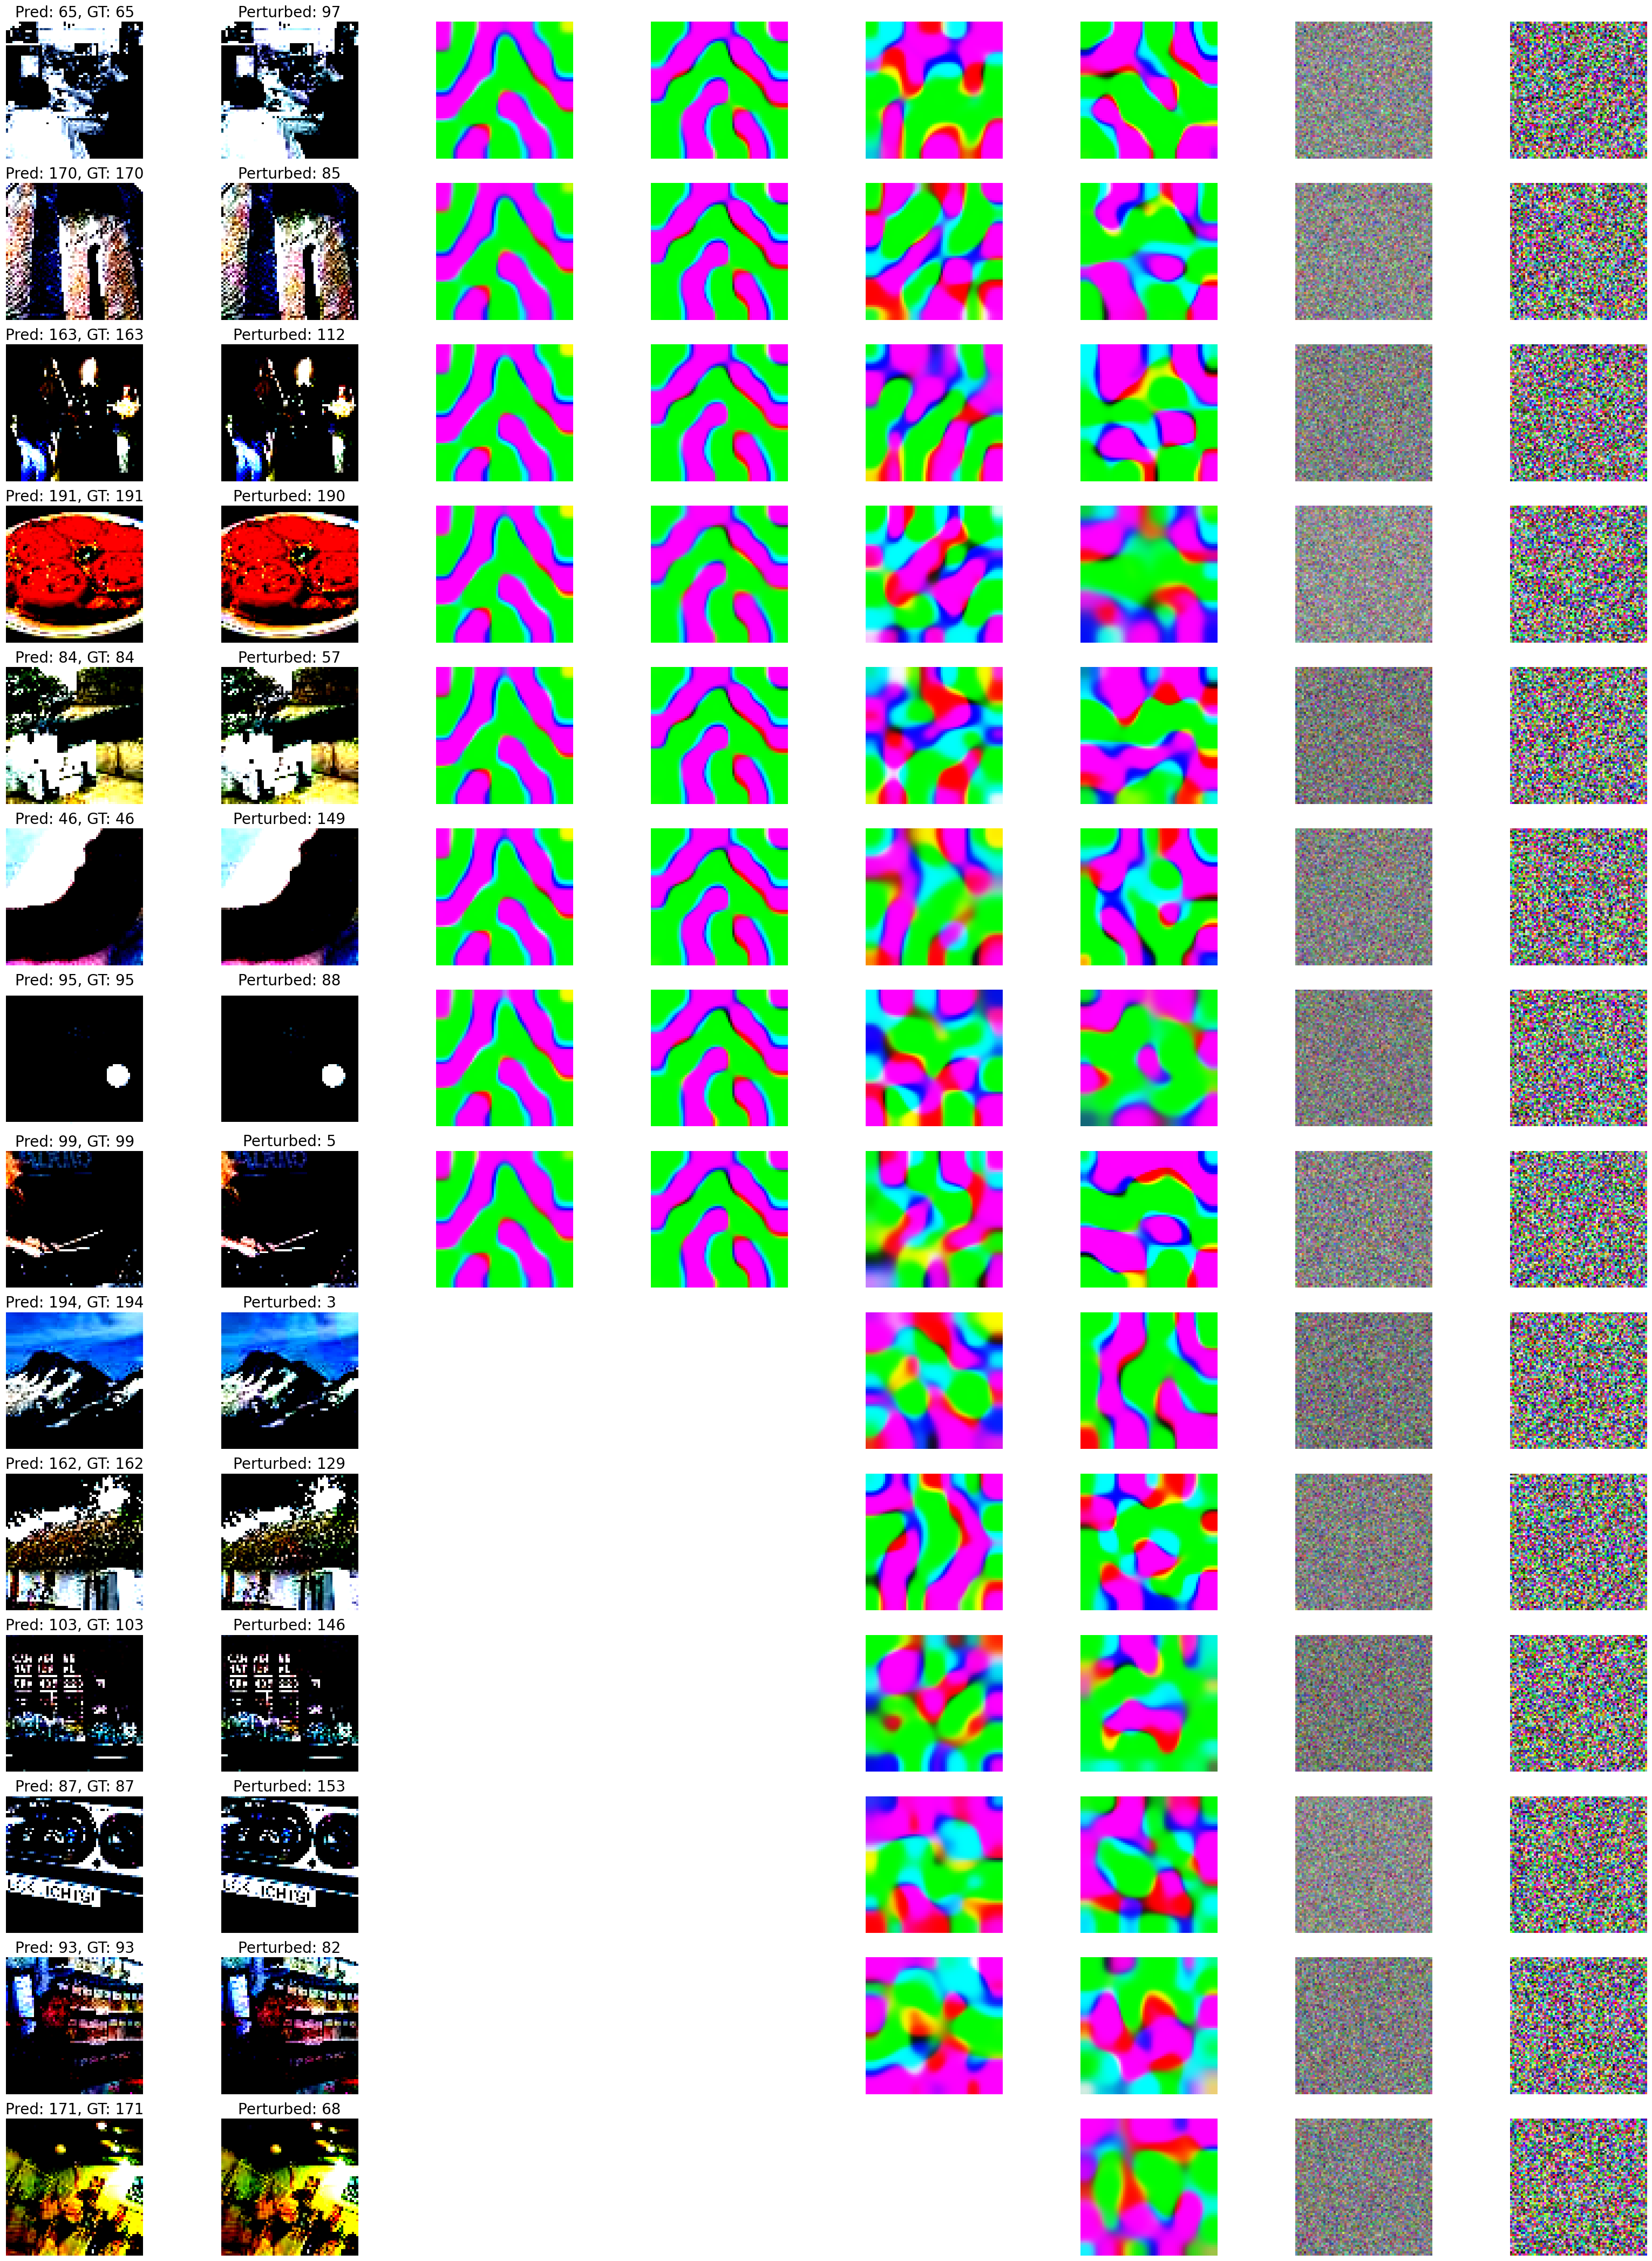

In [2]:
# Plot perturbations with all dependency modes
fig, axes = plot_perturbations(
    succ_images, succ_ground_truth,
    list_succ_perturbations, list_succ_labels,
    original_predictions=succ_ground_truth,
    normalize_perturbation=True,
    dependency_modes=dependency_modes
)
plt.show()
